# Quora Question Pairs (Data Analysis)
In this notebook we provided an analysis of the data contained in the training and test set downloaded from the Kaggle competion (https://www.kaggle.com/c/quora-question-pairs/overview)

## Download and unzip of the data
To download the data it is important to install kaggle and use it for the download, since the version downloaded doesn't support the command competitions download we also force it to update using --no-deps.

In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! pip install --upgrade --force-reinstall --no-deps kaggle

! kaggle competitions download quora-question-pairs

! unzip quora-question-pairs.zip
! unzip train.csv.zip
! unzip test.csv.z
! unzip sample_submission.csv.zip

Saving kaggle.json to kaggle.json
     |████████████████████████████████| 58 kB 3.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=671f4bc79992fcf3e103b36cf75a95ee8112b40956df874f3be787cf1c43b789
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 96% 298M/309M [00:02<00:00, 116MB/s]
100% 309M/309M [00:02<00:00, 136MB/s]
Archive:  quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               
unzip:  cannot find or open test.csv.z, test.csv.z.zip or test.csv.z.ZIP.
Archive:  sample_submission.csv.zip
  inflating: sample_submission.cs

## Data Exploration


In [ ]:
import pandas as pd
import numpy as np
import os

import scipy
import string
import csv

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objects as go 

import re

import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Training Data Analysis

In [ ]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


General DataFrame informations:

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


#### Distribution of data points among classes (is_duplicate)

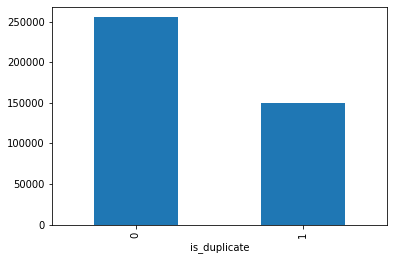

In [ ]:
train_df.groupby('is_duplicate')['id'].count().plot.bar()

In numbers/percenteges:

In [ ]:
print('Total number of question pairs for training:\t\t{}'.format(len(train_df)))
print('Question pairs are not Similar (is_duplicate = 0):\t{}%'.format(100 - round(train_df['is_duplicate'].mean()*100, 2)))
print('Question pairs are Similar (is_duplicate = 1):\t\t{}%'.format(round(train_df['is_duplicate'].mean()*100, 2)))

Total number of question pairs for training:		404290
Question pairs are not Similar (is_duplicate = 0):	63.08%
Question pairs are Similar (is_duplicate = 1):		36.92%


#### Number of unique questions

In [ ]:
qids = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Total number of  Unique Questions are: {}'.format(unique_qs))
print('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print('Max number of times a single question is repeated: {}'.format(max(qids.value_counts())))

Total number of  Unique Questions are: 537933
Number of unique questions that appear more than one time: 111780 (20.77953945937505%)
Max number of times a single question is repeated: 157


#### Plotting the unique and repeated questions count

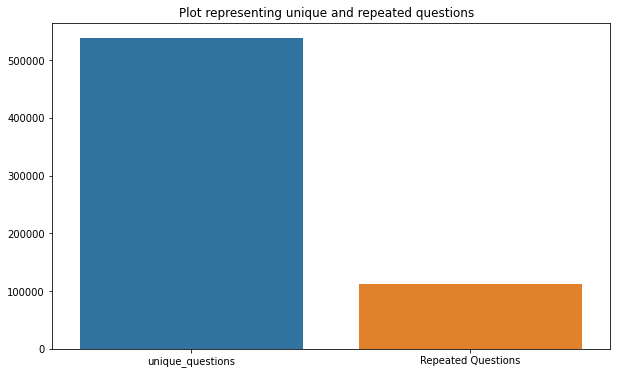

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

#### Number of occurrences of each question

Maximum number of times a single question is repeated: 157



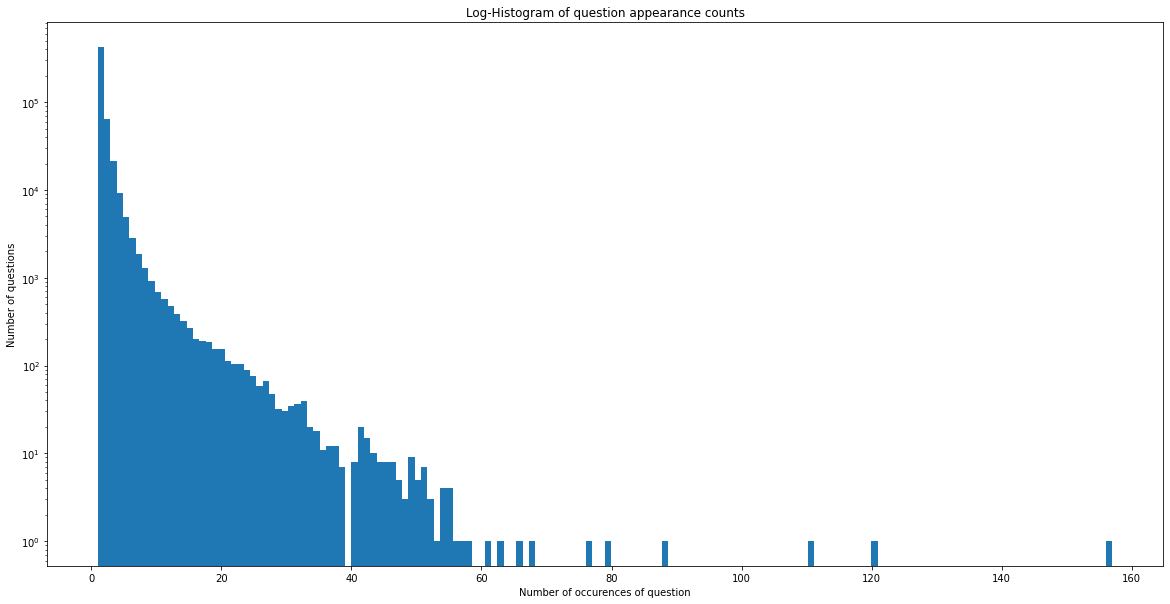

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160) # because the max number is 157 (as printed)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

#### Checking for duplicates pairs (if any)

In [ ]:
pair_duplicates = train_df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - train_df.shape[0])

Number of duplicate questions 0


####Checking for NULL values

In [ ]:
nan_rows = train_df[train_df.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


Here there are two possibilities:


1.   Remove the rows containing a NaN;
2.   Fill the null values with ' '


In [ ]:
# For removing:
train_df = train_df[train_df['question1'].notna()]
train_df = train_df[train_df['question2'].notna()]
# For filling:
train_df = train_df.fillna('')

In [ ]:
nan_rows = train_df[train_df.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate


### Newly generated sets
In this section we analyse the information inside the three sets (training, validation, test) generated in the "Data Preprocessing" notebook.

#### Retrieving the sets
The three sets are stored in the "Dataset" folder.

In [ ]:
DATASETS_PATH = '/content/drive/MyDrive/Quora/Dataset/'

train_df = pd.read_csv(DATASETS_PATH + 'training.csv')
val_df = pd.read_csv(DATASETS_PATH + 'validation.csv')
test_df = pd.read_csv(DATASETS_PATH + 'test.csv')

##### Training Data Analysis
In this section we focus on the training data and we perform the following operations:


*   Analyse distribution of data
*   Find number of unique questions
*   Plotting the count of unique and repated questions



###### Distribution of data points among classes (is_duplicate)

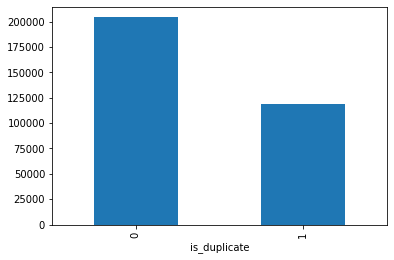

In [ ]:
train_df.groupby('is_duplicate')['id'].count().plot.bar()

In numbers/percenteges:

In [ ]:
print('Total number of question pairs for training:\t\t{}'.format(len(train_df)))
print('Question pairs are not Similar (is_duplicate = 0):\t{}%'.format(100 - round(train_df['is_duplicate'].mean()*100, 2)))
print('Question pairs are Similar (is_duplicate = 1):\t\t{}%'.format(round(train_df['is_duplicate'].mean()*100, 2)))

Total number of question pairs for training:		323431
Question pairs are not Similar (is_duplicate = 0):	63.14%
Question pairs are Similar (is_duplicate = 1):		36.86%


###### Number of unique questions

In [ ]:
qids = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Total number of  Unique Questions are: {}'.format(unique_qs))
print('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print('Max number of times a single question is repeated: {}'.format(max(qids.value_counts())))

Total number of  Unique Questions are: 450352
Number of unique questions that appear more than one time: 85762 (19.04332610935446%)
Max number of times a single question is repeated: 129


###### Plotting the unique and repeated questions count

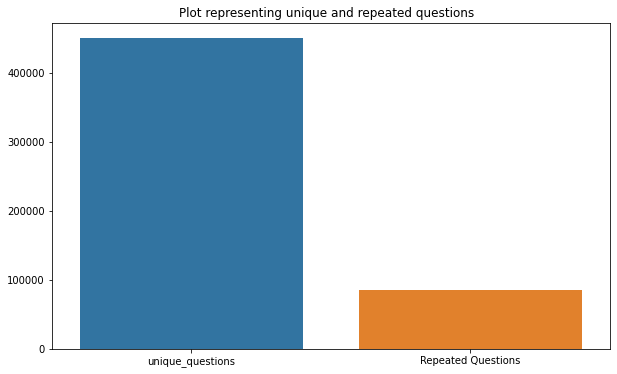

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

###### Number of occurrences of each question

Maximum number of times a single question is repeated: 129



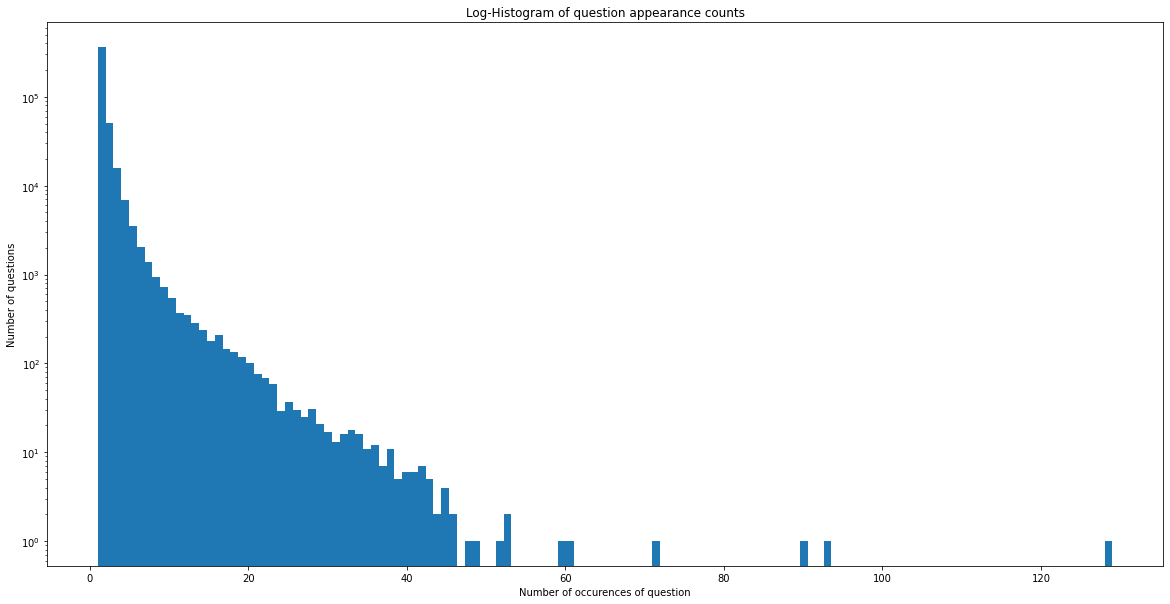

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=130) # because the max number is 129 (as printed)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

##### Validation Data Analysis
In this section we focus on the validation data and we perform the following operations:


*   Analyse distribution of data
*   Find number of unique questions
*   Plotting the count of unique and repeated questions



###### Distribution of data points among classes (is_duplicate)

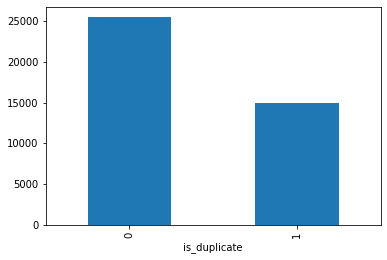

In [ ]:
val_df.groupby('is_duplicate')['id'].count().plot.bar()

In numbers/percenteges:

In [ ]:
print('Total number of question pairs for training:\t\t{}'.format(len(val_df)))
print('Question pairs are not Similar (is_duplicate = 0):\t{}%'.format(100 - round(val_df['is_duplicate'].mean()*100, 2)))
print('Question pairs are Similar (is_duplicate = 1):\t\t{}%'.format(round(val_df['is_duplicate'].mean()*100, 2)))

Total number of question pairs for training:		40428
Question pairs are not Similar (is_duplicate = 0):	63.0%
Question pairs are Similar (is_duplicate = 1):		37.0%


###### Number of unique questions

In [ ]:
qids = pd.Series(val_df['qid1'].tolist() + val_df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Total number of  Unique Questions are: {}'.format(unique_qs))
print('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print('Max number of times a single question is repeated: {}'.format(max(qids.value_counts())))

Total number of  Unique Questions are: 73085
Number of unique questions that appear more than one time: 5448 (7.454333994663748%)
Max number of times a single question is repeated: 16


###### Plotting the unique and repeated questions count

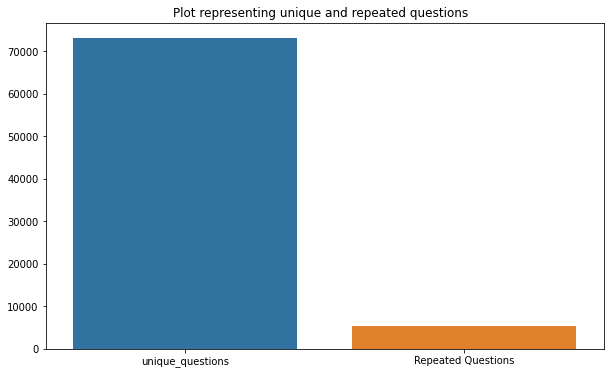

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

###### Number of occurrences of each question

Maximum number of times a single question is repeated: 16



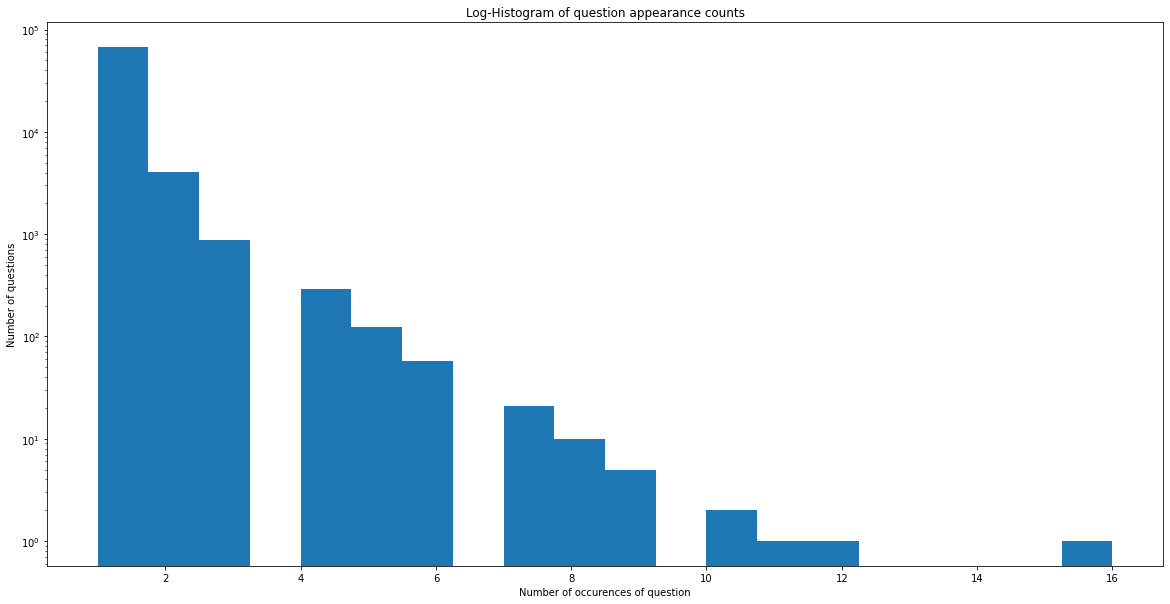

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=20) # because the max number is 16 (as printed)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

##### Test Data Analysis
In this section we focus on the test set data and we perform the following operations:


*   Analyse distribution of data
*   Find number of unique questions
*   Plotting the count of unique and repated questions



###### Distribution of data points among classes (is_duplicate)

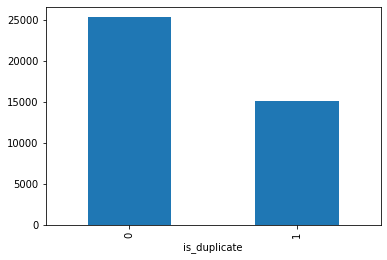

In [ ]:
test_df.groupby('is_duplicate')['id'].count().plot.bar()

In numbers/percenteges:

In [ ]:
print('Total number of question pairs for training:\t\t{}'.format(len(test_df)))
print('Question pairs are not Similar (is_duplicate = 0):\t{}%'.format(100 - round(test_df['is_duplicate'].mean()*100, 2)))
print('Question pairs are Similar (is_duplicate = 1):\t\t{}%'.format(round(test_df['is_duplicate'].mean()*100, 2)))

Total number of question pairs for training:		40428
Question pairs are not Similar (is_duplicate = 0):	62.7%
Question pairs are Similar (is_duplicate = 1):		37.3%


###### Number of unique questions

In [ ]:
qids = pd.Series(test_df['qid1'].tolist() + test_df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Total number of  Unique Questions are: {}'.format(unique_qs))
print('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print('Max number of times a single question is repeated: {}'.format(max(qids.value_counts())))

Total number of  Unique Questions are: 73132
Number of unique questions that appear more than one time: 5367 (7.338784663348466%)
Max number of times a single question is repeated: 16


###### Plotting the unique and repeated questions count

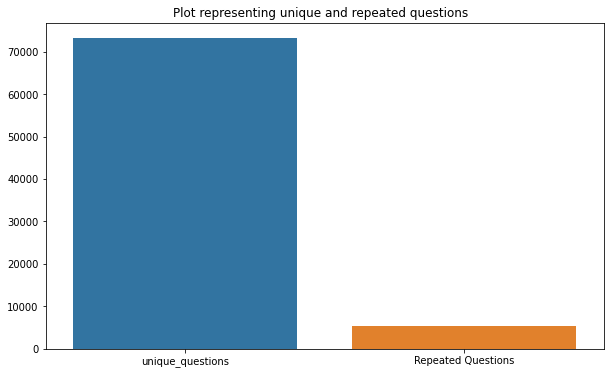

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

###### Number of occurrences of each question

Maximum number of times a single question is repeated: 16



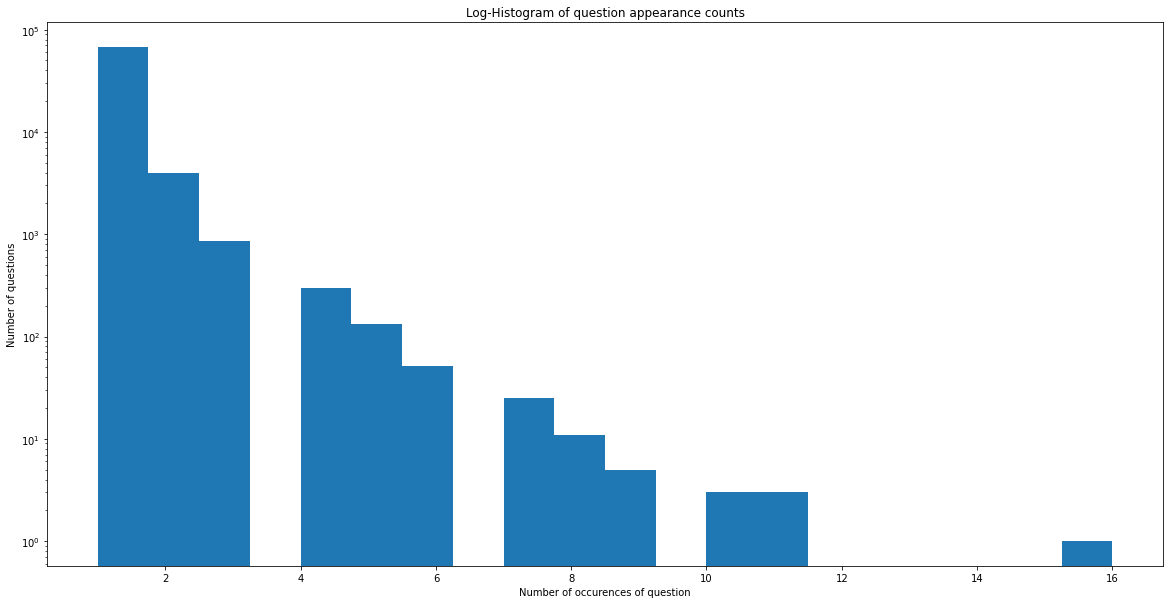

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=20) # because the max number is 16 (as printed)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 